# Metody ewolucyjne i uczenie się maszyn
## Na kilku zadaniach klasyfikacji z repozytorium UCI porównać metody xgboost i catboost
### Agnieszka Czaplicka, Bartosz Sowul

# test: instalacja potrzebnych modułów

In [3]:
!pip install catboost
!pip install xgboost
!pip install matplotlib
!pip install pandas==0.20.3
!pip install numpy
!pip install scikit_learn
!pip install xlrd

## Ładowanie potrzebnych modułów

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold

## Funkcje pomocnicze

### Przygotowanie zbiorów

In [2]:
# zbiory Adult/Annealing/Breast/CTG

from sklearn.preprocessing import MinMaxScaler, Imputer

def prepare(filename):
    if filename[-7:] == 'CTG.xls':
        df = pd.read_excel(filename, sheetname='Data', header=None, parse_cols='K:AE,AT', skiprows=2, nrows=2126)
        print(df.tail())
        df = df[:-3]
        print(df.tail())
    else:
        df = pd.read_csv(filename, header=None)
    
    if filename[-32:] == 'breast-cancer-wisconsin.data.txt':
        df[6] = df[6].replace('?', 0)
        df[6] = df[6].astype('int', errors='ignore')
        df[6] = df[6].replace(0, np.median(df[6]))
    #print(df.dtypes)

    array = df.values
    X = array[:, 0:df.shape[1]-1]
    print('Przetwarzanie wstępne...')
    for i in range(np.shape(X)[1]):
        if df[i].dtype == object:
            names_in_col = df[i].unique()
            names_in_col = sorted(names_in_col, key=lambda v: (v.lower(), v))
            if names_in_col[0].strip() == '?':
                names_in_col = names_in_col[1:]
            elif names_in_col[len(names_in_col) - 1].strip() == '?':
                names_in_col = names_in_col[:-1]
            #print(names_in_col)
            col_dict = dict(zip(names_in_col, range(1, len(names_in_col)+1)))
            X[:, i] = np.array([col_dict.get(elem, np.NaN) for elem in df[i]])
        else:
            df[i] = df[i].replace('?', np.NaN)
            # df[i] = df[i].fillna(value=0)
            X[:, i] = np.array(df[i])

    if df[df.shape[1]-1].dtype == object:
        names_in_col = df[df.shape[1]-1].unique()
        names_in_col = sorted(names_in_col, key=lambda v: (v.lower(), v))
        #print(names_in_col)
        col_dict = dict(zip(names_in_col, range(len(names_in_col))))
        y = np.array([col_dict.get(elem) for elem in df[df.shape[1]-1]])
    else:
        y = array[:, df.shape[1]-1]

    imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
    X = imputer.fit_transform(X)
    # scaler = MinMaxScaler(feature_range=(0, 1)) # skalowanie przy walidacji
    # X = scaler.fit_transform(X)
    print('Przetworzono.')
    return X, y


print("Adult")
X, y = prepare('./data/adult/adult.data.txt')
print("\n------------------------------------------------\n\nAnnealing")
X2, y2 = prepare('./data/annealing/anneal.data.txt')
X2 = X2[:, np.concatenate((np.arange(5), [8, 26, 27, 28, 29, 31]), axis=None)]
print("\n------------------------------------------------\n\nBreast")
X3, y3 = prepare('./data/breast/breast-cancer-wisconsin.data.txt')
X3 = X3[:, 1:]
print("\n------------------------------------------------\n\nCTG")
X4, y4 = prepare('./data/cardiotocography/CTG.xls')


Adult
Przetwarzanie wstępne...
Przetworzono.

------------------------------------------------

Annealing
Przetwarzanie wstępne...
Przetworzono.

------------------------------------------------

Breast
Przetwarzanie wstępne...
Przetworzono.

------------------------------------------------

CTG


/home/agnieszka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  import sys


       0         1         2         3    4    5    6   7    8   9  ...   12  \
2121  140  0.000000  0.000000  0.007426  0.0  0.0  0.0  79  0.2  25 ...  137   
2122  140  0.000775  0.000000  0.006971  0.0  0.0  0.0  78  0.4  22 ...  103   
2123  140  0.000980  0.000000  0.006863  0.0  0.0  0.0  79  0.4  20 ...  103   
2124  140  0.000679  0.000000  0.006110  0.0  0.0  0.0  78  0.4  27 ...  103   
2125  142  0.001616  0.001616  0.008078  0.0  0.0  0.0  74  0.4  36 ...  117   

       13  14  15   16   17   18  19  20  21  
2121  177   4   0  153  150  152   2   0   2  
2122  169   6   0  152  148  151   3   1   2  
2123  170   5   0  153  148  152   4   1   2  
2124  169   6   0  152  147  151   4   1   2  
2125  159   2   1  145  143  145   1   0   1  

[5 rows x 22 columns]
       0         1    2         3         4    5    6   7    8   9  ...   12  \
2118  140  0.000000  0.0  0.006470  0.000924  0.0  0.0  79  0.5  26 ...  129   
2119  140  0.000000  0.0  0.006764  0.001127  0.0  0.0

/home/agnieszka/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


### K-krotna walidacja krzyżowa

In [3]:
def cross_validation(X, y, K, clf):
    n = np.shape(X)[0]
    K_cv_ind = np.random.permutation(n)
    for k in range(K):
        print('\nk = ', k)
        ind_test = K_cv_ind[round(k * (1 / K) * n): round((k+1) * (1 / K) * n)]
        #print('test:', ind_test)
        X_test = X[ind_test, :]
        y_test = y[ind_test]
        if k != 0:
            ind_train = K_cv_ind[np.concatenate((np.arange(round(k * (1 / K) * n)),
                                                 np.arange(round((k+1) * (1 / K) * n), n)), axis=None)]
            X_train = X[ind_train, :]
            y_train = y[ind_train]
        else:
            ind_train = K_cv_ind[range(round((k+1) * (1 / K) * n), n)]
            X_train = X[ind_train, :]
            y_train = y[ind_train]
        #print('train:', ind_train)

        max_train = np.amax(X_train, axis=0)
        min_train = np.amin(X_train, axis=0)
        X_train = 2 * (X_train - min_train) / (max_train - min_train) - 1
        X_test = 2 * (X_test - min_train) / (max_train - min_train) - 1

        find_params(clf, X_train, y_train)
        #params = find_params(clf, X_train, y_train)
        #values = predict(X_test, y_test)
        
#cross_validation(X, y, 5, clf1)

### Optymalizacja hiperparametrów przy użyciu RandomizedSearchCV

### Funkcje pomocnicze do raportowania i zapisu wyników eksperymentów

In [4]:
import csv
from pathlib import Path

def save_results(results, filename='results.csv'):
    mode = 'w'
    path = Path(filename)
    if path.is_file():
         mode = 'a'
    with open(filename, mode) as f, open('params.csv', 'a') as f2:
        w = csv.writer(f)
        w2 = csv.writer(f2)
        if mode == 'w':
            w.writerow(results[0].keys())
        else:
            pass
        for result in results:
            w.writerow(result.values())
            w2.writerow(result.values())
            w2.writerow(result['params'].keys())
            w2.writerow(result['params'].values())

def report(optimizer, algo, scoring, seed, dataset, n_top=3):
    print('BEST')
    print(f"Mean validation score: {optimizer.cv_results_['mean_test_'+scoring[-1]][optimizer.best_index_]:.3f} \
          (std: {optimizer.cv_results_['std_test_'+scoring[-1]][optimizer.best_index_]:.3f})")
    print(f'Params: {optimizer.best_params_}')
    print()
    
    results = []

    for metric in scoring:
        print(f'Najlepsze hiperparametry ze względu na metrykę {metric}:')
        cv_results = [tup[0] for tup in sorted(enumerate(optimizer.cv_results_['mean_test_'+metric]), key=lambda x:x[1])]
        for idx in cv_results[::-1][:3]:
            results.append({'dataset': dataset, 'seed': seed, 'algo': type(algo).__name__,
                            'metric': metric, 'model_id': idx,
                            'mean_test_': optimizer.cv_results_['mean_test_'+metric][idx],
                            'std_test_': optimizer.cv_results_['std_test_'+metric][idx],
                            'params': optimizer.cv_results_['params'][idx]})
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                      optimizer.cv_results_['mean_test_'+metric][idx],
                      optimizer.cv_results_['std_test_'+metric][idx]))
            print("Params: {0}".format(optimizer.cv_results_['params'][idx]))
            print()
    else:
        save_results(results)

In [5]:
#accuracy, F1 score i logloss
from time import time

from catboost import CatBoostClassifier
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

def find_params(clf, scoring, seed, X=None, y=None):
    params = None
    if type(clf) == XGBClassifier:
        print(f'Optymalizacja hiperparametrów {type(clf).__name__}...')
#learning_rate
#gamma
#max_depth
#min_child_weight
#subsample
#colsample_bytree
#reg_alpha
#reg_lambda
#n_estimators
        params = {
            'learning_rate': st.uniform(0.05, 1.0),
            'gamma': st.uniform(0, 10),
            'max_depth': st.randint(3, 17),
            'min_child_weight': st.expon(0, 50),
            'subsample': st.beta(10, 1),
            'colsample_bytree': st.beta(10, 1) ,
            'reg_alpha': st.expon(0, 50),
            'reg_lambda': st.randint(0, 100),
            'n_estimators': st.randint(3, 50),
        }
    elif type(clf) == CatBoostClassifier:
#learning_rate
#depth
#l2_leaf_reg
#rsm
#random_strength
#iterations
        print(f'Optymalizacja hiperparametrów {type(clf).__name__}...')
        params = {
            'learning_rate': st.uniform(0.05, 1.0),
            'depth': st.randint(3, 17),
            'l2_leaf_reg': st.randint(0, 100),
            'rsm': st.uniform(0.0, 1.0),
            'random_strength': st.uniform(0.05, 10),
            'iterations': st.randint(3, 50),
        }
    else:
        print(f'Błąd: {type(clf)} klasyfikator nie jest obsługiwany.')
    
    # run randomized search
    n_iter_search = 10
    random_search = RandomizedSearchCV(clf, param_distributions=params,
                                       n_iter=n_iter_search, cv=StratifiedKFold(5), scoring=scoring,
                                       refit='neg_log_loss', return_train_score=True, random_state=seed)

    start = time()
    random_search.fit(X, y)
    print(f'\nRandomizedSearchCV trwało {time() - start:.2f} sekund dla {n_iter_search} kandydatów.')
    return random_search

## Ustawienie parametrów testów

In [6]:
scoring = ['accuracy', 'f1_weighted', 'neg_log_loss']
seeds = [111*n for n in range(0, 15)]
datasets = ['Annealing', 'Breast', 'CTG', 'Adult']

X2, y2 = prepare('./data/annealing/anneal.data.txt')
X3, y3 = prepare('./data/breast/breast-cancer-wisconsin.data.txt')
X4, y4 = prepare('./data/cardiotocography/CTG.xls')
X1, y1 = prepare('./data/adult/adult.data.txt')

XX = [X2, X3, X4, X1]
yy = [y2, y3, y4, y1]

Przetwarzanie wstępne...
Przetworzono.
Przetwarzanie wstępne...
Przetworzono.


/home/agnieszka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  import sys
/home/agnieszka/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


       0         1         2         3    4    5    6   7    8   9  ...   12  \
2121  140  0.000000  0.000000  0.007426  0.0  0.0  0.0  79  0.2  25 ...  137   
2122  140  0.000775  0.000000  0.006971  0.0  0.0  0.0  78  0.4  22 ...  103   
2123  140  0.000980  0.000000  0.006863  0.0  0.0  0.0  79  0.4  20 ...  103   
2124  140  0.000679  0.000000  0.006110  0.0  0.0  0.0  78  0.4  27 ...  103   
2125  142  0.001616  0.001616  0.008078  0.0  0.0  0.0  74  0.4  36 ...  117   

       13  14  15   16   17   18  19  20  21  
2121  177   4   0  153  150  152   2   0   2  
2122  169   6   0  152  148  151   3   1   2  
2123  170   5   0  153  148  152   4   1   2  
2124  169   6   0  152  147  151   4   1   2  
2125  159   2   1  145  143  145   1   0   1  

[5 rows x 22 columns]
       0         1    2         3         4    5    6   7    8   9  ...   12  \
2118  140  0.000000  0.0  0.006470  0.000924  0.0  0.0  79  0.5  26 ...  129   
2119  140  0.000000  0.0  0.006764  0.001127  0.0  0.0

## TESTY

In [10]:
for seed in seeds:
    for X, y, dataset in zip(XX, yy, datasets):
        print(f'Test zbioru {dataset} przy seedzie {seed}\n')
        xgb = XGBClassifier()
        ctb = CatBoostClassifier(loss_function='MultiClass', verbose=False)

        optimizer_xgb = find_params(xgb, scoring, seed, X, y)
        report(optimizer_xgb, xgb, scoring, seed, dataset)

        optimizer_ctb = find_params(ctb, scoring, seed, X, y)
        report(optimizer_ctb, ctb, scoring, seed, dataset)

Test zbioru Annealing przy seedzie 0

Optymalizacja hiperparametrów XGBClassifier...


/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.09 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.675           (std: 0.025)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.85023973979370426, 'gamma': 6.8005556946341228, 'learning_rate': 0.49919773821837204, 'max_depth': 6, 'min_child_weight': 60.111928002778761, 'n_estimators': 25, 'reg_alpha': 84.046110238441372, 'reg_lambda': 75, 'subsample': 0.9116104529398813}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.99718837648301295, 'gamma': 8.2894002921736316, 'learning_rate': 0.054695476192547068, 'max_depth': 16, 'min_child_weight': 42.154151787034785, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 23.81 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.280           (std: 0.042)
Params: {'depth': 12, 'iterations': 38, 'l2_leaf_reg': 11, 'learning_rate': 0.26038256107384089, 'random_strength': 1.3392629765485331, 'rsm': 0.31542835092418386}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.911 (std: 0.025)
Params: {'depth': 12, 'iterations': 38, 'l2_leaf_reg': 11, 'learning_rate': 0.26038256107384089, 'random_strength': 1.3392629765485331, 'rsm': 0.31542835092418386}

Mean validation score: 0.888 (std: 0.014)
Params: {'depth': 7, 'iterations': 44, 'l2_leaf_reg': 42, 'learning_rate': 0.409507900573786, 'random_strength': 4.4203195379934144, 'rsm': 0.69763119592726486}

Mean validation score: 0.888 (std: 0.018)
Params: {'depth': 9, 'iterations': 42, 'l2_leaf_reg': 87, 'learning_rate': 0.52997717237505737, 'random_strength': 3.9778479610082971, 'rsm': 0.83607876353737753}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.07 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.273           (std: 0.022)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.941 (std: 0.021)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Mean validation score: 0.914 (std: 0.020)
Params: {'colsample_bytree': 0.99718837648301295, 'gamma': 8.2894002921736316, 'learning_rate': 0.054695476192547068, 'max_depth': 16, 'min_child_weight': 42.154151787034785, 'n_est

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 5.61 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.397           (std: 0.152)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.866 (std: 0.058)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Mean validation score: 0.828 (std: 0.109)
Params: {'colsample_bytree': 0.87970882158714636, 'gamma': 1.381829513486138, 'learning_rate': 0.24658236168005349, 'max_depth': 3, 'min_child_weight': 54.313468880808479, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 8.47 sec ignored in overall statistics.

Iteration with suspicious time 10.2 sec ignored in overall statistics.

Iteration with suspicious time 9.95 sec ignored in overall statistics.

Iteration with suspicious time 9.09 sec ignored in overall statistics.

Iteration with suspicious time 9.08 sec ignored in overall statistics.

Iteration with suspicious time 12.1 sec ignored in overall statistics.


KeyboardInterrupt: 

## Testy na zbiorze Annealing

In [12]:
print("Zbiór Annealing")

scoring = ['accuracy', 'f1_weighted', 'neg_log_loss']

dataset = 'Annealing'
X, y = prepare('./data/annealing/anneal.data.txt')

for seed in seeds:
    print(f'Test zbioru {dataset} przy seedzie {seed}\n')
    xgb = XGBClassifier()
    ctb = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    
    optimizer_xgb2 = find_params(xgb, scoring, seed, X, y)
    report(optimizer_xgb2, xgb, scoring, seed, dataset)

    optimizer_ctb2 = find_params(ctb, scoring, seed, X, y)
    report(optimizer_ctb2, ctb, scoring, seed, dataset)

Zbiór Annealing
Przetwarzanie wstępne...
Przetworzono.
Test zbioru Annealing przy seedzie 0

Optymalizacja hiperparametrów XGBClassifier...


/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.12 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.675           (std: 0.025)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.85023973979370426, 'gamma': 6.8005556946341228, 'learning_rate': 0.49919773821837204, 'max_depth': 6, 'min_child_weight': 60.111928002778761, 'n_estimators': 25, 'reg_alpha': 84.046110238441372, 'reg_lambda': 75, 'subsample': 0.9116104529398813}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.99718837648301295, 'gamma': 8.2894002921736316, 'learning_rate': 0.054695476192547068, 'max_depth': 16, 'min_child_weight': 42.154151787034785, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 28.22 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.280           (std: 0.042)
Params: {'depth': 12, 'iterations': 38, 'l2_leaf_reg': 11, 'learning_rate': 0.26038256107384089, 'random_strength': 1.3392629765485331, 'rsm': 0.31542835092418386}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.911 (std: 0.025)
Params: {'depth': 12, 'iterations': 38, 'l2_leaf_reg': 11, 'learning_rate': 0.26038256107384089, 'random_strength': 1.3392629765485331, 'rsm': 0.31542835092418386}

Mean validation score: 0.888 (std: 0.014)
Params: {'depth': 7, 'iterations': 44, 'l2_leaf_reg': 42, 'learning_rate': 0.409507900573786, 'random_strength': 4.4203195379934144, 'rsm': 0.69763119592726486}

Mean validation score: 0.888 (std: 0.018)
Params: {'depth': 9, 'iterations': 42, 'l2_leaf_reg': 87, 'learning_rate': 0.52997717237505737, 'random_strength': 3.9778479610082971, 'rsm': 0.83607876353737753}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.39 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.511           (std: 0.046)
Params: {'colsample_bytree': 0.96822823759893117, 'gamma': 3.6077620064287794, 'learning_rate': 0.8997204066587916, 'max_depth': 11, 'min_child_weight': 19.197911834329673, 'n_estimators': 30, 'reg_alpha': 1.9464979068715309, 'reg_lambda': 13, 'subsample': 0.8665556736882436}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.802 (std: 0.023)
Params: {'colsample_bytree': 0.96822823759893117, 'gamma': 3.6077620064287794, 'learning_rate': 0.8997204066587916, 'max_depth': 11, 'min_child_weight': 19.197911834329673, 'n_estimators': 30, 'reg_alpha': 1.9464979068715309, 'reg_lambda': 13, 'subsample': 0.8665556736882436}

Mean validation score: 0.801 (std: 0.007)
Params: {'colsample_bytree': 0.86900124541044066, 'gamma': 2.1049924581368176, 'learning_rate': 0.85206457718643547, 'max_depth': 3, 'min_child_weight': 8.1923283466419132, 'n_estimators'

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.

Iteration with suspicious time 1.84 sec ignored in overall statistics.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. 


RandomizedSearchCV trwało 40.93 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.272           (std: 0.051)
Params: {'depth': 6, 'iterations': 36, 'l2_leaf_reg': 38, 'learning_rate': 0.89380186955457119, 'random_strength': 7.3120188758759106, 'rsm': 0.27030569335406984}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.900 (std: 0.017)
Params: {'depth': 14, 'iterations': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.58617409413940536, 'random_strength': 0.64287222644790365, 'rsm': 0.64527610987831308}

Mean validation score: 0.895 (std: 0.017)
Params: {'depth': 6, 'iterations': 36, 'l2_leaf_reg': 38, 'learning_rate': 0.89380186955457119, 'random_strength': 7.3120188758759106, 'rsm': 0.27030569335406984}

Mean validation score: 0.888 (std: 0.033)
Params: {'depth': 5, 'iterations': 46, 'l2_leaf_reg': 86, 'learning_rate': 0.84396256047962848, 'random_strength': 8.4556964872428129, 'rsm': 0.81520745745294065}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.05 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.655           (std: 0.030)
Params: {'colsample_bytree': 0.95170981692084688, 'gamma': 2.5161862683269742, 'learning_rate': 0.98452781104888443, 'max_depth': 16, 'min_child_weight': 43.583571756792999, 'n_estimators': 10, 'reg_alpha': 3.3422709031801405, 'reg_lambda': 13, 'subsample': 0.98563629124946361}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.768 (std: 0.008)
Params: {'colsample_bytree': 0.95170981692084688, 'gamma': 2.5161862683269742, 'learning_rate': 0.98452781104888443, 'max_depth': 16, 'min_child_weight': 43.583571756792999, 'n_estimators': 10, 'reg_alpha': 3.3422709031801405, 'reg_lambda': 13, 'subsample': 0.98563629124946361}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.96648986670598203, 'gamma': 3.6205735286781593, 'learning_rate': 1.0453749797681515, 'max_depth': 9, 'min_child_weight': 18.922909022813378, 'n_estimato

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 4.42 sec ignored in overall statistics.

Iteration with suspicious time 3.79 sec ignored in overall statistics.

Iteration with suspicious time 4.66 sec ignored in overall statistics.



RandomizedSearchCV trwało 103.64 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.212           (std: 0.060)
Params: {'depth': 12, 'iterations': 30, 'l2_leaf_reg': 4, 'learning_rate': 0.40915509470067718, 'random_strength': 4.7258903421436473, 'rsm': 0.46122784046875787}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.936 (std: 0.025)
Params: {'depth': 12, 'iterations': 30, 'l2_leaf_reg': 4, 'learning_rate': 0.40915509470067718, 'random_strength': 4.7258903421436473, 'rsm': 0.46122784046875787}

Mean validation score: 0.871 (std: 0.022)
Params: {'depth': 16, 'iterations': 46, 'l2_leaf_reg': 8, 'learning_rate': 0.14621393483232753, 'random_strength': 2.1324967538930815, 'rsm': 0.57654317269310351}

Mean validation score: 0.852 (std: 0.035)
Params: {'depth': 9, 'iterations': 48, 'l2_leaf_reg': 14, 'learning_rate': 0.88567418825970001, 'random_strength': 6.5876525921620033, 'rsm': 0.037021954948116442}

Najlepsze hiperparametry ze względu na met

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 5.21 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.519           (std: 0.034)
Params: {'colsample_bytree': 0.96128786934470789, 'gamma': 3.4771781782620392, 'learning_rate': 0.97071489900568164, 'max_depth': 4, 'min_child_weight': 9.244632099524571, 'n_estimators': 48, 'reg_alpha': 2.1848010329112308, 'reg_lambda': 83, 'subsample': 0.9627842780423278}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.777 (std: 0.016)
Params: {'colsample_bytree': 0.96128786934470789, 'gamma': 3.4771781782620392, 'learning_rate': 0.97071489900568164, 'max_depth': 4, 'min_child_weight': 9.244632099524571, 'n_estimators': 48, 'reg_alpha': 2.1848010329112308, 'reg_lambda': 83, 'subsample': 0.9627842780423278}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.98608278056393939, 'gamma': 7.9118639612213038, 'learning_rate': 0.1691756661573795, 'max_depth': 9, 'min_child_weight': 129.45785942859172, 'n_estimators': 2

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 1.27 sec ignored in overall statistics.

Iteration with suspicious time 2.17 sec ignored in overall statistics.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You pr


RandomizedSearchCV trwało 136.95 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.176           (std: 0.057)
Params: {'depth': 15, 'iterations': 23, 'l2_leaf_reg': 9, 'learning_rate': 1.0155704800820449, 'random_strength': 4.7351387052789402, 'rsm': 0.63005072775259008}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.947 (std: 0.018)
Params: {'depth': 15, 'iterations': 23, 'l2_leaf_reg': 9, 'learning_rate': 1.0155704800820449, 'random_strength': 4.7351387052789402, 'rsm': 0.63005072775259008}

Mean validation score: 0.870 (std: 0.018)
Params: {'depth': 12, 'iterations': 30, 'l2_leaf_reg': 86, 'learning_rate': 0.71511238563595581, 'random_strength': 6.1335708191780602, 'rsm': 0.49375100374754433}

Mean validation score: 0.860 (std: 0.028)
Params: {'depth': 3, 'iterations': 27, 'l2_leaf_reg': 5, 'learning_rate': 0.44410386417230069, 'random_strength': 8.4138399925406304, 'rsm': 0.19688072496803066}

Najlepsze hiperparametry ze względu na metryk

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 3.67 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.784           (std: 0.025)
Params: {'colsample_bytree': 0.95401516615681092, 'gamma': 6.8201628090310322, 'learning_rate': 0.8532161696866013, 'max_depth': 7, 'min_child_weight': 30.528653175763026, 'n_estimators': 47, 'reg_alpha': 17.883127703822641, 'reg_lambda': 47, 'subsample': 0.93603992284276394}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.99407866225206931, 'gamma': 4.1328545377836479, 'learning_rate': 0.80914376630973395, 'max_depth': 5, 'min_child_weight': 56.724831300413513, 'n_estimators': 47, 'reg_alpha': 57.299193795925355, 'reg_lambda': 42, 'subsample': 0.92500665377624547}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.95401516615681092, 'gamma': 6.8201628090310322, 'learning_rate': 0.8532161696866013, 'max_depth': 7, 'min_child_weight': 30.528653175763026, 'n_estimators'

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 1.88 sec ignored in overall statistics.

Iteration with suspicious time 2.3 sec ignored in overall statistics.

Iteration with suspicious time 1.03 sec ignored in overall statistics.



RandomizedSearchCV trwało 67.49 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.227           (std: 0.056)
Params: {'depth': 3, 'iterations': 34, 'l2_leaf_reg': 12, 'learning_rate': 0.89964217095086996, 'random_strength': 8.2869762369004967, 'rsm': 0.94485641737851955}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.927 (std: 0.021)
Params: {'depth': 3, 'iterations': 34, 'l2_leaf_reg': 12, 'learning_rate': 0.89964217095086996, 'random_strength': 8.2869762369004967, 'rsm': 0.94485641737851955}

Mean validation score: 0.922 (std: 0.034)
Params: {'depth': 11, 'iterations': 44, 'l2_leaf_reg': 10, 'learning_rate': 0.36636050352204014, 'random_strength': 1.9859241206374079, 'rsm': 0.19709288205874276}

Mean validation score: 0.917 (std: 0.036)
Params: {'depth': 12, 'iterations': 37, 'l2_leaf_reg': 73, 'learning_rate': 0.83483710117006993, 'random_strength': 7.501481942057465, 'rsm': 0.96568638791712391}

Najlepsze hiperparametry ze względu na metr

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 7.90 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.319           (std: 0.036)
Params: {'colsample_bytree': 0.86988862217327168, 'gamma': 1.6340463112872217, 'learning_rate': 0.52831835903093727, 'max_depth': 4, 'min_child_weight': 2.977055647679907, 'n_estimators': 46, 'reg_alpha': 0.040042726957006967, 'reg_lambda': 32, 'subsample': 0.99719440659462155}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.888 (std: 0.043)
Params: {'colsample_bytree': 0.86988862217327168, 'gamma': 1.6340463112872217, 'learning_rate': 0.52831835903093727, 'max_depth': 4, 'min_child_weight': 2.977055647679907, 'n_estimators': 46, 'reg_alpha': 0.040042726957006967, 'reg_lambda': 32, 'subsample': 0.99719440659462155}

Mean validation score: 0.786 (std: 0.010)
Params: {'colsample_bytree': 0.81197176437430474, 'gamma': 3.6620964089229235, 'learning_rate': 0.51951492272513267, 'max_depth': 14, 'min_child_weight': 6.9525770198549912, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 2.34 sec ignored in overall statistics.

Iteration with suspicious time 2.48 sec ignored in overall statistics.

Iteration with suspicious time 2.67 sec ignored in overall statistics.

Iteration with suspicious time 3.61 sec ignored in overall statistics.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need 


RandomizedSearchCV trwało 190.96 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.184           (std: 0.064)
Params: {'depth': 7, 'iterations': 24, 'l2_leaf_reg': 4, 'learning_rate': 0.72931051531899027, 'random_strength': 2.4916371038334839, 'rsm': 0.80929626082979333}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.940 (std: 0.011)
Params: {'depth': 7, 'iterations': 24, 'l2_leaf_reg': 4, 'learning_rate': 0.72931051531899027, 'random_strength': 2.4916371038334839, 'rsm': 0.80929626082979333}

Mean validation score: 0.939 (std: 0.021)
Params: {'depth': 13, 'iterations': 49, 'l2_leaf_reg': 33, 'learning_rate': 0.99447197759377726, 'random_strength': 6.9138003969194264, 'rsm': 0.58120733419279513}

Mean validation score: 0.937 (std: 0.025)
Params: {'depth': 3, 'iterations': 35, 'l2_leaf_reg': 8, 'learning_rate': 1.0134325313469739, 'random_strength': 9.3665556943837593, 'rsm': 0.86912578056277667}

Najlepsze hiperparametry ze względu na metrykę

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.72 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.723           (std: 0.018)
Params: {'colsample_bytree': 0.66690078037488942, 'gamma': 7.3847112157083821, 'learning_rate': 0.76955060778303774, 'max_depth': 13, 'min_child_weight': 20.895739652822453, 'n_estimators': 19, 'reg_alpha': 10.973155861628401, 'reg_lambda': 36, 'subsample': 0.97248332819211791}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.61103497514683969, 'gamma': 9.0632664635180564, 'learning_rate': 0.10199571092617894, 'max_depth': 11, 'min_child_weight': 34.095874931761337, 'n_estimators': 41, 'reg_alpha': 0.56087428071983092, 'reg_lambda': 85, 'subsample': 0.9808259016043841}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.98434273584992138, 'gamma': 9.3788262182512554, 'learning_rate': 0.96099744380778707, 'max_depth': 11, 'min_child_weight': 16.065995790106271, 'n_estima


Iteration with suspicious time 1.82 sec ignored in overall statistics.
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 2.2 sec ignored in overall statistics.

Iteration with suspicious time 2.49 sec ignored in overall statistics.

Iteration with suspicious time 0.986 sec ignored in overall statistics.

Iteration with suspicious time 4.01 sec ignored in overall statistics.

Iteration with suspicious time 6.2 sec ignored in overall statistics.



RandomizedSearchCV trwało 178.10 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.271           (std: 0.055)
Params: {'depth': 3, 'iterations': 49, 'l2_leaf_reg': 39, 'learning_rate': 0.86995655739972, 'random_strength': 4.0247624621424638, 'rsm': 0.31644109109959084}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.910 (std: 0.024)
Params: {'depth': 3, 'iterations': 49, 'l2_leaf_reg': 39, 'learning_rate': 0.86995655739972, 'random_strength': 4.0247624621424638, 'rsm': 0.31644109109959084}

Mean validation score: 0.866 (std: 0.035)
Params: {'depth': 3, 'iterations': 41, 'l2_leaf_reg': 27, 'learning_rate': 0.41959638089759038, 'random_strength': 0.80166543947191804, 'rsm': 0.77519297845216339}

Mean validation score: 0.817 (std: 0.023)
Params: {'depth': 3, 'iterations': 31, 'l2_leaf_reg': 83, 'learning_rate': 0.67640452675642504, 'random_strength': 8.2387369057781861, 'rsm': 0.54734542037296174}

Najlepsze hiperparametry ze względu na metrykę f

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.41 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.752           (std: 0.017)
Params: {'colsample_bytree': 0.92886182073350188, 'gamma': 3.6233361093722962, 'learning_rate': 0.39420889374469442, 'max_depth': 13, 'min_child_weight': 18.342976698865822, 'n_estimators': 27, 'reg_alpha': 26.828346139718708, 'reg_lambda': 14, 'subsample': 0.96065829602677044}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.90683963304498993, 'gamma': 1.0601250249174887, 'learning_rate': 0.90349238827793266, 'max_depth': 14, 'min_child_weight': 84.974182494077439, 'n_estimators': 27, 'reg_alpha': 88.348613808518962, 'reg_lambda': 13, 'subsample': 0.9094381576344136}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.86303587653157776, 'gamma': 5.4665483886729627, 'learning_rate': 0.61845641733309153, 'max_depth': 15, 'min_child_weight': 34.297929486718637, 'n_estimat

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 85.24 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.176           (std: 0.050)
Params: {'depth': 12, 'iterations': 39, 'l2_leaf_reg': 16, 'learning_rate': 0.82765281954425263, 'random_strength': 2.97481278822855, 'rsm': 0.96504447954518691}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.946 (std: 0.013)
Params: {'depth': 12, 'iterations': 39, 'l2_leaf_reg': 16, 'learning_rate': 0.82765281954425263, 'random_strength': 2.97481278822855, 'rsm': 0.96504447954518691}

Mean validation score: 0.944 (std: 0.016)
Params: {'depth': 12, 'iterations': 49, 'l2_leaf_reg': 24, 'learning_rate': 0.93277275315824948, 'random_strength': 3.9298675420902138, 'rsm': 0.34721661428640227}

Mean validation score: 0.904 (std: 0.027)
Params: {'depth': 10, 'iterations': 41, 'l2_leaf_reg': 87, 'learning_rate': 0.68625429168239493, 'random_strength': 2.5305966641942685, 'rsm': 0.56352904384581026}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 5.08 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.533           (std: 0.040)
Params: {'colsample_bytree': 0.72408103143698599, 'gamma': 6.9613131918791566, 'learning_rate': 0.91965389120624152, 'max_depth': 12, 'min_child_weight': 6.592741347143555, 'n_estimators': 48, 'reg_alpha': 2.0592312456484256, 'reg_lambda': 25, 'subsample': 0.87886317461628594}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.789 (std: 0.010)
Params: {'colsample_bytree': 0.72408103143698599, 'gamma': 6.9613131918791566, 'learning_rate': 0.91965389120624152, 'max_depth': 12, 'min_child_weight': 6.592741347143555, 'n_estimators': 48, 'reg_alpha': 2.0592312456484256, 'reg_lambda': 25, 'subsample': 0.87886317461628594}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.87351930411877876, 'gamma': 2.849160546219097, 'learning_rate': 0.67815055087822684, 'max_depth': 4, 'min_child_weight': 11.652297869690466, 'n_estimators

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater th


RandomizedSearchCV trwało 111.35 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.178           (std: 0.051)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 22, 'learning_rate': 0.83042390883734274, 'random_strength': 1.003943239789935, 'rsm': 0.87351480914250079}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.944 (std: 0.020)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 22, 'learning_rate': 0.83042390883734274, 'random_strength': 1.003943239789935, 'rsm': 0.87351480914250079}

Mean validation score: 0.926 (std: 0.021)
Params: {'depth': 7, 'iterations': 47, 'l2_leaf_reg': 48, 'learning_rate': 1.0274523549854753, 'random_strength': 4.1650139008602256, 'rsm': 0.4583046696146128}

Mean validation score: 0.898 (std: 0.005)
Params: {'depth': 13, 'iterations': 22, 'l2_leaf_reg': 26, 'learning_rate': 0.48201954685279585, 'random_strength': 0.82350125256531959, 'rsm': 0.48788075055304536}

Najlepsze hiperparametry ze względu na metr

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 3.45 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.754           (std: 0.022)
Params: {'colsample_bytree': 0.91037144678656456, 'gamma': 2.234108640047717, 'learning_rate': 0.35611332252765832, 'max_depth': 3, 'min_child_weight': 18.008555586875286, 'n_estimators': 19, 'reg_alpha': 16.742341853570576, 'reg_lambda': 69, 'subsample': 0.79259834339920399}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.85746490966427669, 'gamma': 5.6651826481778258, 'learning_rate': 0.97231069245939161, 'max_depth': 11, 'min_child_weight': 25.776993800158127, 'n_estimators': 12, 'reg_alpha': 19.734491544783754, 'reg_lambda': 58, 'subsample': 0.9394862946137309}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.84442593001375932, 'gamma': 5.5147500562396843, 'learning_rate': 0.93958709851645739, 'max_depth': 10, 'min_child_weight': 9.9957680268439599, 'n_estimator

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 51.55 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.216           (std: 0.063)
Params: {'depth': 3, 'iterations': 48, 'l2_leaf_reg': 8, 'learning_rate': 0.6043858124306527, 'random_strength': 6.331265224775608, 'rsm': 0.69739294419434827}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.936 (std: 0.020)
Params: {'depth': 11, 'iterations': 42, 'l2_leaf_reg': 27, 'learning_rate': 0.46235778831205748, 'random_strength': 2.8663896255962236, 'rsm': 0.3902777805896922}

Mean validation score: 0.927 (std: 0.019)
Params: {'depth': 3, 'iterations': 48, 'l2_leaf_reg': 8, 'learning_rate': 0.6043858124306527, 'random_strength': 6.331265224775608, 'rsm': 0.69739294419434827}

Mean validation score: 0.912 (std: 0.024)
Params: {'depth': 6, 'iterations': 41, 'l2_leaf_reg': 43, 'learning_rate': 0.81043547033931096, 'random_strength': 4.7875837576152422, 'rsm': 0.28671891792287252}

Najlepsze hiperparametry ze względu na metrykę f1_

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.73 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.391           (std: 0.035)
Params: {'colsample_bytree': 0.71204251497773496, 'gamma': 4.0845780540734822, 'learning_rate': 0.15843992876172058, 'max_depth': 13, 'min_child_weight': 0.52679206758963804, 'n_estimators': 41, 'reg_alpha': 0.56557669696102442, 'reg_lambda': 13, 'subsample': 0.92379068361965111}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.842 (std: 0.030)
Params: {'colsample_bytree': 0.71204251497773496, 'gamma': 4.0845780540734822, 'learning_rate': 0.15843992876172058, 'max_depth': 13, 'min_child_weight': 0.52679206758963804, 'n_estimators': 41, 'reg_alpha': 0.56557669696102442, 'reg_lambda': 13, 'subsample': 0.92379068361965111}

Mean validation score: 0.779 (std: 0.015)
Params: {'colsample_bytree': 0.97046376472076112, 'gamma': 0.43296979322161588, 'learning_rate': 0.36684190204302686, 'max_depth': 14, 'min_child_weight': 0.5842639514496264, 'n_e

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 113.81 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.190           (std: 0.060)
Params: {'depth': 15, 'iterations': 17, 'l2_leaf_reg': 5, 'learning_rate': 0.96624317962713613, 'random_strength': 8.3499125390790354, 'rsm': 0.79915694756854705}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.946 (std: 0.021)
Params: {'depth': 15, 'iterations': 17, 'l2_leaf_reg': 5, 'learning_rate': 0.96624317962713613, 'random_strength': 8.3499125390790354, 'rsm': 0.79915694756854705}

Mean validation score: 0.904 (std: 0.029)
Params: {'depth': 6, 'iterations': 40, 'l2_leaf_reg': 77, 'learning_rate': 0.73082165650402919, 'random_strength': 7.0981911148911463, 'rsm': 0.8158482790256496}

Mean validation score: 0.841 (std: 0.039)
Params: {'depth': 10, 'iterations': 17, 'l2_leaf_reg': 28, 'learning_rate': 0.77387071708409583, 'random_strength': 4.7075422264372984, 'rsm': 0.18590013682059991}

Najlepsze hiperparametry ze względu na metr

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 3.72 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.622           (std: 0.029)
Params: {'colsample_bytree': 0.78475090746435683, 'gamma': 0.7238626063267084, 'learning_rate': 0.55884306704813602, 'max_depth': 16, 'min_child_weight': 32.851743853649104, 'n_estimators': 39, 'reg_alpha': 5.2854723115487907, 'reg_lambda': 52, 'subsample': 0.94786739625110383}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.783 (std: 0.014)
Params: {'colsample_bytree': 0.78475090746435683, 'gamma': 0.7238626063267084, 'learning_rate': 0.55884306704813602, 'max_depth': 16, 'min_child_weight': 32.851743853649104, 'n_estimators': 39, 'reg_alpha': 5.2854723115487907, 'reg_lambda': 52, 'subsample': 0.94786739625110383}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.9844899978615409, 'gamma': 0.79611745782415699, 'learning_rate': 0.095457268124718289, 'max_depth': 6, 'min_child_weight': 65.686870219409741, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Iteration with suspicious time 1.89 sec ignored in overall statistics.



RandomizedSearchCV trwało 36.15 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.238           (std: 0.058)
Params: {'depth': 4, 'iterations': 41, 'l2_leaf_reg': 22, 'learning_rate': 0.7040256766689349, 'random_strength': 8.9369829467303905, 'rsm': 0.96035721086170345}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.915 (std: 0.029)
Params: {'depth': 4, 'iterations': 41, 'l2_leaf_reg': 22, 'learning_rate': 0.7040256766689349, 'random_strength': 8.9369829467303905, 'rsm': 0.96035721086170345}

Mean validation score: 0.887 (std: 0.024)
Params: {'depth': 11, 'iterations': 15, 'l2_leaf_reg': 12, 'learning_rate': 0.76039368650523298, 'random_strength': 7.391482578108449, 'rsm': 0.88537109533442093}

Mean validation score: 0.767 (std: 0.003)
Params: {'depth': 15, 'iterations': 11, 'l2_leaf_reg': 77, 'learning_rate': 0.53161386345265005, 'random_strength': 4.8368722006912508, 'rsm': 0.84912983430978639}

Najlepsze hiperparametry ze względu na metryk

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.38 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.538           (std: 0.022)
Params: {'colsample_bytree': 0.92592400977887657, 'gamma': 2.5036011458500882, 'learning_rate': 0.82148114238799141, 'max_depth': 12, 'min_child_weight': 3.5930541211301086, 'n_estimators': 46, 'reg_alpha': 9.0834913091706184, 'reg_lambda': 62, 'subsample': 0.90035381855856189}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.793 (std: 0.017)
Params: {'colsample_bytree': 0.92592400977887657, 'gamma': 2.5036011458500882, 'learning_rate': 0.82148114238799141, 'max_depth': 12, 'min_child_weight': 3.5930541211301086, 'n_estimators': 46, 'reg_alpha': 9.0834913091706184, 'reg_lambda': 62, 'subsample': 0.90035381855856189}

Mean validation score: 0.774 (std: 0.013)
Params: {'colsample_bytree': 0.84576436853653092, 'gamma': 5.3218687712671811, 'learning_rate': 0.62298472851991482, 'max_depth': 11, 'min_child_weight': 8.1291467292926711, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 79.12 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.253           (std: 0.045)
Params: {'depth': 6, 'iterations': 47, 'l2_leaf_reg': 92, 'learning_rate': 0.98094042686520855, 'random_strength': 0.66139406986983174, 'rsm': 0.89997674676106743}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.924 (std: 0.030)
Params: {'depth': 6, 'iterations': 47, 'l2_leaf_reg': 92, 'learning_rate': 0.98094042686520855, 'random_strength': 0.66139406986983174, 'rsm': 0.89997674676106743}

Mean validation score: 0.897 (std: 0.034)
Params: {'depth': 11, 'iterations': 45, 'l2_leaf_reg': 76, 'learning_rate': 0.51479150231441351, 'random_strength': 3.1921340682967392, 'rsm': 0.90928504842427615}

Mean validation score: 0.897 (std: 0.041)
Params: {'depth': 13, 'iterations': 35, 'l2_leaf_reg': 19, 'learning_rate': 0.32202503682407918, 'random_strength': 6.804679036100163, 'rsm': 0.85119447225068845}

Najlepsze hiperparametry ze względu na me

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 4.04 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.600           (std: 0.034)
Params: {'colsample_bytree': 0.9470027861835203, 'gamma': 0.87239791432622504, 'learning_rate': 0.47199367255679608, 'max_depth': 16, 'min_child_weight': 38.849285483265291, 'n_estimators': 49, 'reg_alpha': 0.57148378551809464, 'reg_lambda': 27, 'subsample': 0.90118051791552156}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.781 (std: 0.013)
Params: {'colsample_bytree': 0.9470027861835203, 'gamma': 0.87239791432622504, 'learning_rate': 0.47199367255679608, 'max_depth': 16, 'min_child_weight': 38.849285483265291, 'n_estimators': 49, 'reg_alpha': 0.57148378551809464, 'reg_lambda': 27, 'subsample': 0.90118051791552156}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.86979697898432407, 'gamma': 7.378792183209324, 'learning_rate': 0.93965870389030148, 'max_depth': 3, 'min_child_weight': 29.723941148718584, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater th


RandomizedSearchCV trwało 260.95 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.178           (std: 0.088)
Params: {'depth': 9, 'iterations': 48, 'l2_leaf_reg': 3, 'learning_rate': 1.0337639362904552, 'random_strength': 3.6010401334360274, 'rsm': 0.12218409302241851}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.944 (std: 0.014)
Params: {'depth': 9, 'iterations': 48, 'l2_leaf_reg': 3, 'learning_rate': 1.0337639362904552, 'random_strength': 3.6010401334360274, 'rsm': 0.12218409302241851}

Mean validation score: 0.942 (std: 0.027)
Params: {'depth': 8, 'iterations': 48, 'l2_leaf_reg': 13, 'learning_rate': 0.59625009404000295, 'random_strength': 6.0256008230431997, 'rsm': 0.99851864875211649}

Mean validation score: 0.916 (std: 0.013)
Params: {'depth': 14, 'iterations': 47, 'l2_leaf_reg': 84, 'learning_rate': 0.50120274886919458, 'random_strength': 0.67432491495970526, 'rsm': 0.79281904279625304}

Najlepsze hiperparametry ze względu na metryk

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 3.68 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.702           (std: 0.034)
Params: {'colsample_bytree': 0.95155332065877152, 'gamma': 0.11587131064204281, 'learning_rate': 0.55127938122201181, 'max_depth': 3, 'min_child_weight': 12.090963911948858, 'n_estimators': 47, 'reg_alpha': 26.712336537794869, 'reg_lambda': 94, 'subsample': 0.77350992433529686}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.90861507957508103, 'gamma': 7.5524297277391685, 'learning_rate': 0.095199585423121305, 'max_depth': 11, 'min_child_weight': 151.24403238792434, 'n_estimators': 13, 'reg_alpha': 21.440227167107949, 'reg_lambda': 92, 'subsample': 0.73546471281372006}

Mean validation score: 0.762 (std: 0.005)
Params: {'colsample_bytree': 0.97546094481662693, 'gamma': 6.532811596262194, 'learning_rate': 0.19661149145163986, 'max_depth': 9, 'min_child_weight': 23.741926727042287, 'n_estimat

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 171.73 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.188           (std: 0.059)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 27, 'learning_rate': 0.99618131953081424, 'random_strength': 7.7434159854189426, 'rsm': 0.43478642701713144}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.946 (std: 0.021)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 27, 'learning_rate': 0.99618131953081424, 'random_strength': 7.7434159854189426, 'rsm': 0.43478642701713144}

Mean validation score: 0.915 (std: 0.018)
Params: {'depth': 16, 'iterations': 39, 'l2_leaf_reg': 28, 'learning_rate': 0.63886259261387701, 'random_strength': 6.1497616996517896, 'rsm': 0.20095988066638659}

Mean validation score: 0.866 (std: 0.029)
Params: {'depth': 15, 'iterations': 29, 'l2_leaf_reg': 68, 'learning_rate': 0.64615044772838581, 'random_strength': 9.1517464776580368, 'rsm': 0.4450405843072055}

Najlepsze hiperparametry ze względu na m

## Testy na zbiorze Breast

In [14]:
print("Zbiór Breast")

scoring = ['accuracy', 'f1_weighted', 'neg_log_loss']

dataset = 'Breast'
X, y = prepare('./data/breast/breast-cancer-wisconsin.data.txt')

for seed in seeds:
    print(f'Test zbioru {dataset} przy seedzie {seed}\n')
    xgb = XGBClassifier()
    ctb = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    
    optimizer_xgb3 = find_params(xgb, scoring, seed, X, y)
    report(optimizer_xgb3, xgb, scoring, seed, dataset)

    optimizer_ctb3 = find_params(ctb, scoring, seed, X, y)
    report(optimizer_ctb3, ctb, scoring, seed, dataset)
else:
    print('Done.\n')

Zbiór Breast
Przetwarzanie wstępne...
Przetworzono.
Test zbioru Breast przy seedzie 0

Optymalizacja hiperparametrów XGBClassifier...


/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.01 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.273           (std: 0.022)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.941 (std: 0.021)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Mean validation score: 0.914 (std: 0.020)
Params: {'colsample_bytree': 0.99718837648301295, 'gamma': 8.2894002921736316, 'learning_rate': 0.054695476192547068, 'max_depth': 16, 'min_child_weight': 42.154151787034785, 'n_est

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.08 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.171           (std: 0.039)
Params: {'colsample_bytree': 0.86900124541044066, 'gamma': 2.1049924581368176, 'learning_rate': 0.85206457718643547, 'max_depth': 3, 'min_child_weight': 8.1923283466419132, 'n_estimators': 39, 'reg_alpha': 11.619779341850629, 'reg_lambda': 20, 'subsample': 0.9003944179579163}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.957 (std: 0.025)
Params: {'colsample_bytree': 0.86900124541044066, 'gamma': 2.1049924581368176, 'learning_rate': 0.85206457718643547, 'max_depth': 3, 'min_child_weight': 8.1923283466419132, 'n_estimators': 39, 'reg_alpha': 11.619779341850629, 'reg_lambda': 20, 'subsample': 0.9003944179579163}

Mean validation score: 0.944 (std: 0.025)
Params: {'colsample_bytree': 0.96822823759893117, 'gamma': 3.6077620064287794, 'learning_rate': 0.8997204066587916, 'max_depth': 11, 'min_child_weight': 19.197911834329673, 'n_estimators'

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 34.29 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.122           (std: 0.053)
Params: {'depth': 5, 'iterations': 46, 'l2_leaf_reg': 86, 'learning_rate': 0.84396256047962848, 'random_strength': 8.4556964872428129, 'rsm': 0.81520745745294065}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.971 (std: 0.017)
Params: {'depth': 7, 'iterations': 47, 'l2_leaf_reg': 84, 'learning_rate': 0.35178945091410735, 'random_strength': 8.5890645838724424, 'rsm': 0.29771597903464209}

Mean validation score: 0.967 (std: 0.017)
Params: {'depth': 9, 'iterations': 15, 'l2_leaf_reg': 45, 'learning_rate': 0.77029827882514457, 'random_strength': 3.8606000511622236, 'rsm': 0.62423656935958238}

Mean validation score: 0.963 (std: 0.023)
Params: {'depth': 14, 'iterations': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.58617409413940536, 'random_strength': 0.64287222644790365, 'rsm': 0.64527610987831308}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 0.90 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.214           (std: 0.041)
Params: {'colsample_bytree': 0.95494375696129852, 'gamma': 5.5121308434406071, 'learning_rate': 0.85667672517779681, 'max_depth': 3, 'min_child_weight': 23.309202599307277, 'n_estimators': 23, 'reg_alpha': 12.938482379710445, 'reg_lambda': 7, 'subsample': 0.78149775735077831}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.940 (std: 0.031)
Params: {'colsample_bytree': 0.67792856549373015, 'gamma': 5.1646966582376876, 'learning_rate': 0.48763584440122171, 'max_depth': 16, 'min_child_weight': 5.592796161048776, 'n_estimators': 37, 'reg_alpha': 21.887726716807297, 'reg_lambda': 86, 'subsample': 0.95633291347081095}

Mean validation score: 0.936 (std: 0.034)
Params: {'colsample_bytree': 0.94174563902545683, 'gamma': 0.37021954948116442, 'learning_rate': 0.2301556632282496, 'max_depth': 14, 'min_child_weight': 22.415072603857407, 'n_estimator

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.10 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.160           (std: 0.039)
Params: {'colsample_bytree': 0.96128786934470789, 'gamma': 3.4771781782620392, 'learning_rate': 0.97071489900568164, 'max_depth': 4, 'min_child_weight': 9.244632099524571, 'n_estimators': 48, 'reg_alpha': 2.1848010329112308, 'reg_lambda': 83, 'subsample': 0.9627842780423278}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.957 (std: 0.021)
Params: {'colsample_bytree': 0.98553037068933158, 'gamma': 3.6817888587403305, 'learning_rate': 0.30910889501323852, 'max_depth': 9, 'min_child_weight': 19.612111895384121, 'n_estimators': 40, 'reg_alpha': 2.1451775255603658, 'reg_lambda': 71, 'subsample': 0.98886035545460427}

Mean validation score: 0.957 (std: 0.025)
Params: {'colsample_bytree': 0.96128786934470789, 'gamma': 3.4771781782620392, 'learning_rate': 0.97071489900568164, 'max_depth': 4, 'min_child_weight': 9.244632099524571, 'n_estimators':

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 101.79 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.113           (std: 0.057)
Params: {'depth': 3, 'iterations': 27, 'l2_leaf_reg': 5, 'learning_rate': 0.44410386417230069, 'random_strength': 8.4138399925406304, 'rsm': 0.19688072496803066}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.967 (std: 0.020)
Params: {'depth': 15, 'iterations': 15, 'l2_leaf_reg': 77, 'learning_rate': 0.57255091828764559, 'random_strength': 3.3781501628710915, 'rsm': 0.59732628888429562}

Mean validation score: 0.964 (std: 0.027)
Params: {'depth': 6, 'iterations': 15, 'l2_leaf_reg': 26, 'learning_rate': 0.18648177479443812, 'random_strength': 1.4713320228627824, 'rsm': 0.52952225600824521}

Mean validation score: 0.963 (std: 0.018)
Params: {'depth': 6, 'iterations': 32, 'l2_leaf_reg': 71, 'learning_rate': 0.15453018817247083, 'random_strength': 1.0243751561636538, 'rsm': 0.24540331451355435}

Najlepsze hiperparametry ze względu na metr

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.52 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.248           (std: 0.031)
Params: {'colsample_bytree': 0.95401516615681092, 'gamma': 6.8201628090310322, 'learning_rate': 0.8532161696866013, 'max_depth': 7, 'min_child_weight': 30.528653175763026, 'n_estimators': 47, 'reg_alpha': 17.883127703822641, 'reg_lambda': 47, 'subsample': 0.93603992284276394}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.947 (std: 0.021)
Params: {'colsample_bytree': 0.95401516615681092, 'gamma': 6.8201628090310322, 'learning_rate': 0.8532161696866013, 'max_depth': 7, 'min_child_weight': 30.528653175763026, 'n_estimators': 47, 'reg_alpha': 17.883127703822641, 'reg_lambda': 47, 'subsample': 0.93603992284276394}

Mean validation score: 0.917 (std: 0.025)
Params: {'colsample_bytree': 0.91785007618786407, 'gamma': 8.4964217095086987, 'learning_rate': 0.87369762369004955, 'max_depth': 16, 'min_child_weight': 49.277300069617318, 'n_estimators

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 45.82 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.118           (std: 0.058)
Params: {'depth': 11, 'iterations': 44, 'l2_leaf_reg': 10, 'learning_rate': 0.36636050352204014, 'random_strength': 1.9859241206374079, 'rsm': 0.19709288205874276}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.964 (std: 0.023)
Params: {'depth': 14, 'iterations': 47, 'l2_leaf_reg': 65, 'learning_rate': 0.26446669844287379, 'random_strength': 1.0438385471469835, 'rsm': 0.058396914097033292}

Mean validation score: 0.961 (std: 0.022)
Params: {'depth': 6, 'iterations': 29, 'l2_leaf_reg': 72, 'learning_rate': 0.5852167228571924, 'random_strength': 7.1495325076511298, 'rsm': 0.55905773954326399}

Mean validation score: 0.961 (std: 0.019)
Params: {'depth': 15, 'iterations': 13, 'l2_leaf_reg': 16, 'learning_rate': 0.76486377229813285, 'random_strength': 5.3355119660304702, 'rsm': 0.93173526595092671}

Najlepsze hiperparametry ze względu na me

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 0.97 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.125           (std: 0.055)
Params: {'colsample_bytree': 0.86988862217327168, 'gamma': 1.6340463112872217, 'learning_rate': 0.52831835903093727, 'max_depth': 4, 'min_child_weight': 2.977055647679907, 'n_estimators': 46, 'reg_alpha': 0.040042726957006967, 'reg_lambda': 32, 'subsample': 0.99719440659462155}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.957 (std: 0.027)
Params: {'colsample_bytree': 0.86988862217327168, 'gamma': 1.6340463112872217, 'learning_rate': 0.52831835903093727, 'max_depth': 4, 'min_child_weight': 2.977055647679907, 'n_estimators': 46, 'reg_alpha': 0.040042726957006967, 'reg_lambda': 32, 'subsample': 0.99719440659462155}

Mean validation score: 0.951 (std: 0.021)
Params: {'colsample_bytree': 0.81197176437430474, 'gamma': 3.6620964089229235, 'learning_rate': 0.51951492272513267, 'max_depth': 14, 'min_child_weight': 6.9525770198549912, 'n_estima


Iteration with suspicious time 1.25 sec ignored in overall statistics.

Iteration with suspicious time 4.75 sec ignored in overall statistics.

Iteration with suspicious time 2.26 sec ignored in overall statistics.

Iteration with suspicious time 4.51 sec ignored in overall statistics.

Iteration with suspicious time 5.09 sec ignored in overall statistics.

Iteration with suspicious time 1.76 sec ignored in overall statistics.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is great


RandomizedSearchCV trwało 90.48 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.116           (std: 0.051)
Params: {'depth': 3, 'iterations': 45, 'l2_leaf_reg': 51, 'learning_rate': 0.53734575451122002, 'random_strength': 6.4317852136867861, 'rsm': 0.18509382079222481}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.964 (std: 0.015)
Params: {'depth': 16, 'iterations': 22, 'l2_leaf_reg': 67, 'learning_rate': 0.61296712822278387, 'random_strength': 2.1133490738465297, 'rsm': 0.51901626149184243}

Mean validation score: 0.961 (std: 0.022)
Params: {'depth': 3, 'iterations': 45, 'l2_leaf_reg': 51, 'learning_rate': 0.53734575451122002, 'random_strength': 6.4317852136867861, 'rsm': 0.18509382079222481}

Mean validation score: 0.959 (std: 0.023)
Params: {'depth': 7, 'iterations': 24, 'l2_leaf_reg': 4, 'learning_rate': 0.72931051531899027, 'random_strength': 2.4916371038334839, 'rsm': 0.80929626082979333}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.76 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.209           (std: 0.030)
Params: {'colsample_bytree': 0.66690078037488942, 'gamma': 7.3847112157083821, 'learning_rate': 0.76955060778303774, 'max_depth': 13, 'min_child_weight': 20.895739652822453, 'n_estimators': 19, 'reg_alpha': 10.973155861628401, 'reg_lambda': 36, 'subsample': 0.97248332819211791}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.944 (std: 0.008)
Params: {'colsample_bytree': 0.66690078037488942, 'gamma': 7.3847112157083821, 'learning_rate': 0.76955060778303774, 'max_depth': 13, 'min_child_weight': 20.895739652822453, 'n_estimators': 19, 'reg_alpha': 10.973155861628401, 'reg_lambda': 36, 'subsample': 0.97248332819211791}

Mean validation score: 0.943 (std: 0.025)
Params: {'colsample_bytree': 0.61103497514683969, 'gamma': 9.0632664635180564, 'learning_rate': 0.10199571092617894, 'max_depth': 11, 'min_child_weight': 34.095874931761337, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.02 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.254           (std: 0.027)
Params: {'colsample_bytree': 0.92886182073350188, 'gamma': 3.6233361093722962, 'learning_rate': 0.39420889374469442, 'max_depth': 13, 'min_child_weight': 18.342976698865822, 'n_estimators': 27, 'reg_alpha': 26.828346139718708, 'reg_lambda': 14, 'subsample': 0.96065829602677044}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.943 (std: 0.032)
Params: {'colsample_bytree': 0.92886182073350188, 'gamma': 3.6233361093722962, 'learning_rate': 0.39420889374469442, 'max_depth': 13, 'min_child_weight': 18.342976698865822, 'n_estimators': 27, 'reg_alpha': 26.828346139718708, 'reg_lambda': 14, 'subsample': 0.96065829602677044}

Mean validation score: 0.943 (std: 0.025)
Params: {'colsample_bytree': 0.84019869220694143, 'gamma': 6.8177927978095321, 'learning_rate': 0.60225681373715989, 'max_depth': 7, 'min_child_weight': 6.3752300535840005, 'n_estimat

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.06 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.161           (std: 0.042)
Params: {'colsample_bytree': 0.72408103143698599, 'gamma': 6.9613131918791566, 'learning_rate': 0.91965389120624152, 'max_depth': 12, 'min_child_weight': 6.592741347143555, 'n_estimators': 48, 'reg_alpha': 2.0592312456484256, 'reg_lambda': 25, 'subsample': 0.87886317461628594}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.953 (std: 0.026)
Params: {'colsample_bytree': 0.72408103143698599, 'gamma': 6.9613131918791566, 'learning_rate': 0.91965389120624152, 'max_depth': 12, 'min_child_weight': 6.592741347143555, 'n_estimators': 48, 'reg_alpha': 2.0592312456484256, 'reg_lambda': 25, 'subsample': 0.87886317461628594}

Mean validation score: 0.950 (std: 0.021)
Params: {'colsample_bytree': 0.99021723946830986, 'gamma': 0.59743458120714021, 'learning_rate': 0.17334144134890234, 'max_depth': 5, 'min_child_weight': 29.53741409184526, 'n_estimator

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 54.34 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.122           (std: 0.053)
Params: {'depth': 7, 'iterations': 47, 'l2_leaf_reg': 48, 'learning_rate': 1.0274523549854753, 'random_strength': 4.1650139008602256, 'rsm': 0.4583046696146128}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.966 (std: 0.019)
Params: {'depth': 13, 'iterations': 22, 'l2_leaf_reg': 26, 'learning_rate': 0.48201954685279585, 'random_strength': 0.82350125256531959, 'rsm': 0.48788075055304536}

Mean validation score: 0.961 (std: 0.022)
Params: {'depth': 4, 'iterations': 19, 'l2_leaf_reg': 93, 'learning_rate': 0.70760153838321116, 'random_strength': 1.3795283812164183, 'rsm': 0.53344892506236075}

Mean validation score: 0.960 (std: 0.027)
Params: {'depth': 4, 'iterations': 31, 'l2_leaf_reg': 71, 'learning_rate': 0.40815326171775107, 'random_strength': 9.0632288363033773, 'rsm': 0.38868626576813559}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 0.82 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.249           (std: 0.027)
Params: {'colsample_bytree': 0.91037144678656456, 'gamma': 2.234108640047717, 'learning_rate': 0.35611332252765832, 'max_depth': 3, 'min_child_weight': 18.008555586875286, 'n_estimators': 19, 'reg_alpha': 16.742341853570576, 'reg_lambda': 69, 'subsample': 0.79259834339920399}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.943 (std: 0.025)
Params: {'colsample_bytree': 0.91037144678656456, 'gamma': 2.234108640047717, 'learning_rate': 0.35611332252765832, 'max_depth': 3, 'min_child_weight': 18.008555586875286, 'n_estimators': 19, 'reg_alpha': 16.742341853570576, 'reg_lambda': 69, 'subsample': 0.79259834339920399}

Mean validation score: 0.941 (std: 0.026)
Params: {'colsample_bytree': 0.84442593001375932, 'gamma': 5.5147500562396843, 'learning_rate': 0.93958709851645739, 'max_depth': 10, 'min_child_weight': 9.9957680268439599, 'n_estimators

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.31 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.135           (std: 0.051)
Params: {'colsample_bytree': 0.71204251497773496, 'gamma': 4.0845780540734822, 'learning_rate': 0.15843992876172058, 'max_depth': 13, 'min_child_weight': 0.52679206758963804, 'n_estimators': 41, 'reg_alpha': 0.56557669696102442, 'reg_lambda': 13, 'subsample': 0.92379068361965111}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.956 (std: 0.027)
Params: {'colsample_bytree': 0.71204251497773496, 'gamma': 4.0845780540734822, 'learning_rate': 0.15843992876172058, 'max_depth': 13, 'min_child_weight': 0.52679206758963804, 'n_estimators': 41, 'reg_alpha': 0.56557669696102442, 'reg_lambda': 13, 'subsample': 0.92379068361965111}

Mean validation score: 0.944 (std: 0.021)
Params: {'colsample_bytree': 0.95175203287601839, 'gamma': 6.6925424370794637, 'learning_rate': 0.66479094079210943, 'max_depth': 5, 'min_child_weight': 11.919293047589258, 'n_est


Iteration with suspicious time 1.27 sec ignored in overall statistics.

Iteration with suspicious time 0.25 sec ignored in overall statistics.



RandomizedSearchCV trwało 62.51 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.113           (std: 0.053)
Params: {'depth': 15, 'iterations': 17, 'l2_leaf_reg': 5, 'learning_rate': 0.96624317962713613, 'random_strength': 8.3499125390790354, 'rsm': 0.79915694756854705}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.967 (std: 0.018)
Params: {'depth': 11, 'iterations': 23, 'l2_leaf_reg': 66, 'learning_rate': 0.53576727199438601, 'random_strength': 8.7353790269556857, 'rsm': 0.3714729886826349}

Mean validation score: 0.964 (std: 0.021)
Params: {'depth': 13, 'iterations': 42, 'l2_leaf_reg': 91, 'learning_rate': 0.44121456956378319, 'random_strength': 6.7425424370794635, 'rsm': 0.61479094079210939}

Mean validation score: 0.963 (std: 0.023)
Params: {'depth': 7, 'iterations': 48, 'l2_leaf_reg': 24, 'learning_rate': 0.15779317959895128, 'random_strength': 1.7913551341152278, 'rsm': 0.6605563183944646}

Najlepsze hiperparametry ze względu na metry

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.19 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.217           (std: 0.036)
Params: {'colsample_bytree': 0.78475090746435683, 'gamma': 0.7238626063267084, 'learning_rate': 0.55884306704813602, 'max_depth': 16, 'min_child_weight': 32.851743853649104, 'n_estimators': 39, 'reg_alpha': 5.2854723115487907, 'reg_lambda': 52, 'subsample': 0.94786739625110383}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.947 (std: 0.024)
Params: {'colsample_bytree': 0.78475090746435683, 'gamma': 0.7238626063267084, 'learning_rate': 0.55884306704813602, 'max_depth': 16, 'min_child_weight': 32.851743853649104, 'n_estimators': 39, 'reg_alpha': 5.2854723115487907, 'reg_lambda': 52, 'subsample': 0.94786739625110383}

Mean validation score: 0.930 (std: 0.023)
Params: {'colsample_bytree': 0.77192424685100114, 'gamma': 1.1930510982412001, 'learning_rate': 0.84509738341590313, 'max_depth': 8, 'min_child_weight': 49.631808203092149, 'n_estimat

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.13 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.170           (std: 0.041)
Params: {'colsample_bytree': 0.84576436853653092, 'gamma': 5.3218687712671811, 'learning_rate': 0.62298472851991482, 'max_depth': 11, 'min_child_weight': 8.1291467292926711, 'n_estimators': 22, 'reg_alpha': 4.0488248228649244, 'reg_lambda': 28, 'subsample': 0.83110697264900557}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.953 (std: 0.025)
Params: {'colsample_bytree': 0.84576436853653092, 'gamma': 5.3218687712671811, 'learning_rate': 0.62298472851991482, 'max_depth': 11, 'min_child_weight': 8.1291467292926711, 'n_estimators': 22, 'reg_alpha': 4.0488248228649244, 'reg_lambda': 28, 'subsample': 0.83110697264900557}

Mean validation score: 0.951 (std: 0.022)
Params: {'colsample_bytree': 0.92592400977887657, 'gamma': 2.5036011458500882, 'learning_rate': 0.82148114238799141, 'max_depth': 12, 'min_child_weight': 3.5930541211301086, 'n_estima

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 1.08 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.258           (std: 0.026)
Params: {'colsample_bytree': 0.85684595323820378, 'gamma': 6.9952722452578344, 'learning_rate': 0.4760848326535248, 'max_depth': 3, 'min_child_weight': 8.0483873993698634, 'n_estimators': 45, 'reg_alpha': 16.280651581253974, 'reg_lambda': 84, 'subsample': 0.98760509078692937}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.948 (std: 0.016)
Params: {'colsample_bytree': 0.9470027861835203, 'gamma': 0.87239791432622504, 'learning_rate': 0.47199367255679608, 'max_depth': 16, 'min_child_weight': 38.849285483265291, 'n_estimators': 49, 'reg_alpha': 0.57148378551809464, 'reg_lambda': 27, 'subsample': 0.90118051791552156}

Mean validation score: 0.941 (std: 0.020)
Params: {'colsample_bytree': 0.85684595323820378, 'gamma': 6.9952722452578344, 'learning_rate': 0.4760848326535248, 'max_depth': 3, 'min_child_weight': 8.0483873993698634, 'n_estimator

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 95.23 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.110           (std: 0.048)
Params: {'depth': 3, 'iterations': 22, 'l2_leaf_reg': 25, 'learning_rate': 0.46071028842540224, 'random_strength': 2.7700487385172354, 'rsm': 0.31277368098313874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.967 (std: 0.018)
Params: {'depth': 16, 'iterations': 32, 'l2_leaf_reg': 78, 'learning_rate': 0.44660573759201611, 'random_strength': 4.831289043644305, 'rsm': 0.47379609759977315}

Mean validation score: 0.963 (std: 0.016)
Params: {'depth': 3, 'iterations': 22, 'l2_leaf_reg': 25, 'learning_rate': 0.46071028842540224, 'random_strength': 2.7700487385172354, 'rsm': 0.31277368098313874}

Mean validation score: 0.963 (std: 0.023)
Params: {'depth': 12, 'iterations': 39, 'l2_leaf_reg': 11, 'learning_rate': 0.11213484913016254, 'random_strength': 0.76798594561040323, 'rsm': 0.15559777724403012}

Najlepsze hiperparametry ze względu na met

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 


RandomizedSearchCV trwało 0.90 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.207           (std: 0.033)
Params: {'colsample_bytree': 0.67703369264183955, 'gamma': 6.4028671316932613, 'learning_rate': 0.35632644478261905, 'max_depth': 6, 'min_child_weight': 24.80536862086241, 'n_estimators': 30, 'reg_alpha': 8.906916079824919, 'reg_lambda': 21, 'subsample': 0.8593258155875817}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.946 (std: 0.022)
Params: {'colsample_bytree': 0.67703369264183955, 'gamma': 6.4028671316932613, 'learning_rate': 0.35632644478261905, 'max_depth': 6, 'min_child_weight': 24.80536862086241, 'n_estimators': 30, 'reg_alpha': 8.906916079824919, 'reg_lambda': 21, 'subsample': 0.8593258155875817}

Mean validation score: 0.940 (std: 0.033)
Params: {'colsample_bytree': 0.95155332065877152, 'gamma': 0.11587131064204281, 'learning_rate': 0.55127938122201181, 'max_depth': 3, 'min_child_weight': 12.090963911948858, 'n_estimators': 4


Iteration with suspicious time 0.646 sec ignored in overall statistics.

Iteration with suspicious time 0.631 sec ignored in overall statistics.

Iteration with suspicious time 0.667 sec ignored in overall statistics.



RandomizedSearchCV trwało 60.60 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.117           (std: 0.054)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 27, 'learning_rate': 0.99618131953081424, 'random_strength': 7.7434159854189426, 'rsm': 0.43478642701713144}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.969 (std: 0.021)
Params: {'depth': 6, 'iterations': 37, 'l2_leaf_reg': 99, 'learning_rate': 0.29029261336749473, 'random_strength': 6.4083060702273746, 'rsm': 0.37355856982970947}

Mean validation score: 0.961 (std: 0.013)
Params: {'depth': 10, 'iterations': 12, 'l2_leaf_reg': 21, 'learning_rate': 0.91027965019544976, 'random_strength': 7.3615696497664223, 'rsm': 0.72950419213897844}

Mean validation score: 0.960 (std: 0.020)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 27, 'learning_rate': 0.99618131953081424, 'random_strength': 7.7434159854189426, 'rsm': 0.43478642701713144}

Najlepsze hiperparametry ze względu na me

## Testy na zbiorze CTG

In [ ]:
print("Zbiór CTG")

scoring = ['accuracy', 'f1_weighted', 'neg_log_loss']

dataset = 'CTG'
X, y = prepare('./data/cardiotocography/CTG.xls')

for seed in seeds:
    print(f'Test zbioru {dataset} przy seedzie {seed}\n')
    xgb = XGBClassifier()
    ctb = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    
    optimizer_xgb4 = find_params(xgb, scoring, seed, X, y)
    report(optimizer_xgb4, xgb, scoring, seed, dataset)

    optimizer_ctb4 = find_params(ctb, scoring, seed, X, y)
    report(optimizer_ctb4, ctb, scoring, seed, dataset)
else:
    print('Done.\n')

Zbiór CTG


/home/agnieszka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  import sys
/home/agnieszka/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


       0         1         2         3    4    5    6   7    8   9  ...   12  \
2121  140  0.000000  0.000000  0.007426  0.0  0.0  0.0  79  0.2  25 ...  137   
2122  140  0.000775  0.000000  0.006971  0.0  0.0  0.0  78  0.4  22 ...  103   
2123  140  0.000980  0.000000  0.006863  0.0  0.0  0.0  79  0.4  20 ...  103   
2124  140  0.000679  0.000000  0.006110  0.0  0.0  0.0  78  0.4  27 ...  103   
2125  142  0.001616  0.001616  0.008078  0.0  0.0  0.0  74  0.4  36 ...  117   

       13  14  15   16   17   18  19  20  21  
2121  177   4   0  153  150  152   2   0   2  
2122  169   6   0  152  148  151   3   1   2  
2123  170   5   0  153  148  152   4   1   2  
2124  169   6   0  152  147  151   4   1   2  
2125  159   2   1  145  143  145   1   0   1  

[5 rows x 22 columns]
       0         1    2         3         4    5    6   7    8   9  ...   12  \
2118  140  0.000000  0.0  0.006470  0.000924  0.0  0.0  79  0.5  26 ...  129   
2119  140  0.000000  0.0  0.006764  0.001127  0.0  0.0

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agnieszka/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but


RandomizedSearchCV trwało 5.54 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.393           (std: 0.152)
Params: {'colsample_bytree': 0.9420363254888287, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.8419140682937087}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.864 (std: 0.048)
Params: {'colsample_bytree': 0.9420363254888287, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.8419140682937087}

Mean validation score: 0.826 (std: 0.104)
Params: {'colsample_bytree': 0.8797088215871464, 'gamma': 1.381829513486138, 'learning_rate': 0.24658236168005349, 'max_depth': 3, 'min_child_weight': 54.31346888080848, 'n_estimators':

## Testy na zbiorze Adult

In [13]:
print("Zbiór Adult")

scoring = ['accuracy', 'f1_weighted', 'neg_log_loss']

dataset = 'Adult'
X, y = prepare('./data/adult/adult.data.txt')

for seed in seeds:
    print(f'Test zbioru {dataset} przy seedzie {seed}\n')
    xgb = XGBClassifier()
    ctb = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    
    optimizer_xgb1 = find_params(xgb, scoring, seed, X, y)
    report(optimizer_xgb1, xgb, scoring, seed, dataset)

    optimizer_ctb1 = find_params(ctb, scoring, seed, X, y)
    report(optimizer_ctb1, ctb, scoring, seed, dataset)
else:
    print('Done.\n')

Zbiór Adult
Przetwarzanie wstępne...
Przetworzono.
Test zbioru Adult przy seedzie 0

Optymalizacja hiperparametrów XGBClassifier...

RandomizedSearchCV trwało 50.93 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.302           (std: 0.005)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.865 (std: 0.004)
Params: {'colsample_bytree': 0.94203632548882865, 'gamma': 0.19987665408758737, 'learning_rate': 0.49171092124884536, 'max_depth': 14, 'min_child_weight': 6.4028380737264925, 'n_estimators': 26, 'reg_alpha': 32.782313697880426, 'reg_lambda': 98, 'subsample': 0.84191406829370874}

Mean validation score: 0.860 (std: 0.004)
Params: {'colsample_bytree': 0.83870821640103754

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 319.70 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.291           (std: 0.004)
Params: {'depth': 5, 'iterations': 46, 'l2_leaf_reg': 86, 'learning_rate': 0.84396256047962848, 'random_strength': 8.4556964872428129, 'rsm': 0.81520745745294065}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.867 (std: 0.005)
Params: {'depth': 5, 'iterations': 46, 'l2_leaf_reg': 86, 'learning_rate': 0.84396256047962848, 'random_strength': 8.4556964872428129, 'rsm': 0.81520745745294065}

Mean validation score: 0.865 (std: 0.004)
Params: {'depth': 6, 'iterations': 36, 'l2_leaf_reg': 38, 'learning_rate': 0.89380186955457119, 'random_strength': 7.3120188758759106, 'rsm': 0.27030569335406984}

Mean validation score: 0.859 (std: 0.003)
Params: {'depth': 7, 'iterations': 47, 'l2_leaf_reg': 84, 'learning_rate': 0.35178945091410735, 'random_strength': 8.5890645838724424, 'rsm': 0.29771597903464209}

Najlepsze hiperparametry ze względu na metr


Iteration with suspicious time 10.2 sec ignored in overall statistics.

Iteration with suspicious time 10.3 sec ignored in overall statistics.

Iteration with suspicious time 10.8 sec ignored in overall statistics.



RandomizedSearchCV trwało 950.20 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.295           (std: 0.004)
Params: {'depth': 12, 'iterations': 30, 'l2_leaf_reg': 4, 'learning_rate': 0.40915509470067718, 'random_strength': 4.7258903421436473, 'rsm': 0.46122784046875787}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.864 (std: 0.003)
Params: {'depth': 12, 'iterations': 30, 'l2_leaf_reg': 4, 'learning_rate': 0.40915509470067718, 'random_strength': 4.7258903421436473, 'rsm': 0.46122784046875787}

Mean validation score: 0.861 (std: 0.004)
Params: {'depth': 16, 'iterations': 46, 'l2_leaf_reg': 8, 'learning_rate': 0.14621393483232753, 'random_strength': 2.1324967538930815, 'rsm': 0.57654317269310351}

Mean validation score: 0.855 (std: 0.005)
Params: {'depth': 9, 'iterations': 7, 'l2_leaf_reg': 98, 'learning_rate': 0.91904354541926259, 'random_strength': 1.3995625029681635, 'rsm': 0.582102452009569}

Najlepsze hiperparametry ze względu na metrykę

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 750.29 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.289           (std: 0.003)
Params: {'depth': 15, 'iterations': 23, 'l2_leaf_reg': 9, 'learning_rate': 1.0155704800820449, 'random_strength': 4.7351387052789402, 'rsm': 0.63005072775259008}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.866 (std: 0.003)
Params: {'depth': 15, 'iterations': 23, 'l2_leaf_reg': 9, 'learning_rate': 1.0155704800820449, 'random_strength': 4.7351387052789402, 'rsm': 0.63005072775259008}

Mean validation score: 0.864 (std: 0.005)
Params: {'depth': 12, 'iterations': 30, 'l2_leaf_reg': 86, 'learning_rate': 0.71511238563595581, 'random_strength': 6.1335708191780602, 'rsm': 0.49375100374754433}

Mean validation score: 0.854 (std: 0.004)
Params: {'depth': 15, 'iterations': 15, 'l2_leaf_reg': 77, 'learning_rate': 0.57255091828764559, 'random_strength': 3.3781501628710915, 'rsm': 0.59732628888429562}

Najlepsze hiperparametry ze względu na metr

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 366.23 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.287           (std: 0.005)
Params: {'depth': 12, 'iterations': 37, 'l2_leaf_reg': 73, 'learning_rate': 0.83483710117006993, 'random_strength': 7.501481942057465, 'rsm': 0.96568638791712391}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.870 (std: 0.004)
Params: {'depth': 12, 'iterations': 37, 'l2_leaf_reg': 73, 'learning_rate': 0.83483710117006993, 'random_strength': 7.501481942057465, 'rsm': 0.96568638791712391}

Mean validation score: 0.866 (std: 0.005)
Params: {'depth': 11, 'iterations': 44, 'l2_leaf_reg': 10, 'learning_rate': 0.36636050352204014, 'random_strength': 1.9859241206374079, 'rsm': 0.19709288205874276}

Mean validation score: 0.865 (std: 0.004)
Params: {'depth': 3, 'iterations': 34, 'l2_leaf_reg': 12, 'learning_rate': 0.89964217095086996, 'random_strength': 8.2869762369004967, 'rsm': 0.94485641737851955}

Najlepsze hiperparametry ze względu na met

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 718.97 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.287           (std: 0.005)
Params: {'depth': 13, 'iterations': 49, 'l2_leaf_reg': 33, 'learning_rate': 0.99447197759377726, 'random_strength': 6.9138003969194264, 'rsm': 0.58120733419279513}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.868 (std: 0.004)
Params: {'depth': 13, 'iterations': 49, 'l2_leaf_reg': 33, 'learning_rate': 0.99447197759377726, 'random_strength': 6.9138003969194264, 'rsm': 0.58120733419279513}

Mean validation score: 0.866 (std: 0.005)
Params: {'depth': 7, 'iterations': 24, 'l2_leaf_reg': 4, 'learning_rate': 0.72931051531899027, 'random_strength': 2.4916371038334839, 'rsm': 0.80929626082979333}

Mean validation score: 0.865 (std: 0.004)
Params: {'depth': 3, 'iterations': 35, 'l2_leaf_reg': 8, 'learning_rate': 1.0134325313469739, 'random_strength': 9.3665556943837593, 'rsm': 0.86912578056277667}

Najlepsze hiperparametry ze względu na metry


Iteration with suspicious time 11 sec ignored in overall statistics.

Iteration with suspicious time 10.9 sec ignored in overall statistics.

Iteration with suspicious time 11 sec ignored in overall statistics.

Iteration with suspicious time 10.8 sec ignored in overall statistics.

Iteration with suspicious time 10.7 sec ignored in overall statistics.

Iteration with suspicious time 11 sec ignored in overall statistics.



RandomizedSearchCV trwało 1470.15 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.296           (std: 0.006)
Params: {'depth': 3, 'iterations': 49, 'l2_leaf_reg': 39, 'learning_rate': 0.86995655739972, 'random_strength': 4.0247624621424638, 'rsm': 0.31644109109959084}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.864 (std: 0.004)
Params: {'depth': 3, 'iterations': 49, 'l2_leaf_reg': 39, 'learning_rate': 0.86995655739972, 'random_strength': 4.0247624621424638, 'rsm': 0.31644109109959084}

Mean validation score: 0.861 (std: 0.003)
Params: {'depth': 3, 'iterations': 41, 'l2_leaf_reg': 27, 'learning_rate': 0.41959638089759038, 'random_strength': 0.80166543947191804, 'rsm': 0.77519297845216339}

Mean validation score: 0.857 (std: 0.004)
Params: {'depth': 3, 'iterations': 31, 'l2_leaf_reg': 83, 'learning_rate': 0.67640452675642504, 'random_strength': 8.2387369057781861, 'rsm': 0.54734542037296174}

Najlepsze hiperparametry ze względu na metrykę 

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 345.63 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.283           (std: 0.005)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 22, 'learning_rate': 0.83042390883734274, 'random_strength': 1.003943239789935, 'rsm': 0.87351480914250079}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.871 (std: 0.003)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 22, 'learning_rate': 0.83042390883734274, 'random_strength': 1.003943239789935, 'rsm': 0.87351480914250079}

Mean validation score: 0.869 (std: 0.004)
Params: {'depth': 7, 'iterations': 47, 'l2_leaf_reg': 48, 'learning_rate': 1.0274523549854753, 'random_strength': 4.1650139008602256, 'rsm': 0.4583046696146128}

Mean validation score: 0.866 (std: 0.003)
Params: {'depth': 13, 'iterations': 22, 'l2_leaf_reg': 26, 'learning_rate': 0.48201954685279585, 'random_strength': 0.82350125256531959, 'rsm': 0.48788075055304536}

Najlepsze hiperparametry ze względu na metr

/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 240.91 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.289           (std: 0.004)
Params: {'depth': 11, 'iterations': 42, 'l2_leaf_reg': 27, 'learning_rate': 0.46235778831205748, 'random_strength': 2.8663896255962236, 'rsm': 0.3902777805896922}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.868 (std: 0.004)
Params: {'depth': 13, 'iterations': 46, 'l2_leaf_reg': 78, 'learning_rate': 0.45514183627531674, 'random_strength': 8.72968707036061, 'rsm': 0.50328774703970058}

Mean validation score: 0.867 (std: 0.003)
Params: {'depth': 11, 'iterations': 42, 'l2_leaf_reg': 27, 'learning_rate': 0.46235778831205748, 'random_strength': 2.8663896255962236, 'rsm': 0.3902777805896922}

Mean validation score: 0.866 (std: 0.004)
Params: {'depth': 3, 'iterations': 48, 'l2_leaf_reg': 8, 'learning_rate': 0.6043858124306527, 'random_strength': 6.331265224775608, 'rsm': 0.69739294419434827}

Najlepsze hiperparametry ze względu na metrykę 

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l


RandomizedSearchCV trwało 1001.55 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.283           (std: 0.004)
Params: {'depth': 8, 'iterations': 48, 'l2_leaf_reg': 13, 'learning_rate': 0.59625009404000295, 'random_strength': 6.0256008230431997, 'rsm': 0.99851864875211649}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.871 (std: 0.003)
Params: {'depth': 14, 'iterations': 47, 'l2_leaf_reg': 84, 'learning_rate': 0.50120274886919458, 'random_strength': 0.67432491495970526, 'rsm': 0.79281904279625304}

Mean validation score: 0.871 (std: 0.004)
Params: {'depth': 8, 'iterations': 48, 'l2_leaf_reg': 13, 'learning_rate': 0.59625009404000295, 'random_strength': 6.0256008230431997, 'rsm': 0.99851864875211649}

Mean validation score: 0.866 (std: 0.004)
Params: {'depth': 12, 'iterations': 32, 'l2_leaf_reg': 55, 'learning_rate': 0.40217668314456684, 'random_strength': 0.92239791432622509, 'rsm': 0.4219936725567961}

Najlepsze hiperparametry ze względu na 


Iteration with suspicious time 4.87 sec ignored in overall statistics.
/media/bs/data/projects/0_moje_portfolio/eiti/eiti/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RandomizedSearchCV trwało 758.42 sekund dla 10 kandydatów.
BEST
Mean validation score: -0.287           (std: 0.004)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 27, 'learning_rate': 0.99618131953081424, 'random_strength': 7.7434159854189426, 'rsm': 0.43478642701713144}

Najlepsze hiperparametry ze względu na metrykę accuracy:
Mean validation score: 0.869 (std: 0.002)
Params: {'depth': 13, 'iterations': 48, 'l2_leaf_reg': 27, 'learning_rate': 0.99618131953081424, 'random_strength': 7.7434159854189426, 'rsm': 0.43478642701713144}

Mean validation score: 0.866 (std: 0.005)
Params: {'depth': 16, 'iterations': 39, 'l2_leaf_reg': 28, 'learning_rate': 0.63886259261387701, 'random_strength': 6.1497616996517896, 'rsm': 0.20095988066638659}

Mean validation score: 0.866 (std: 0.004)
Params: {'depth': 15, 'iterations': 29, 'l2_leaf_reg': 68, 'learning_rate': 0.64615044772838581, 'random_strength': 9.1517464776580368, 'rsm': 0.4450405843072055}

Najlepsze hiperparametry ze względu na m

## Wykres pudełkowy rozkładów optymalizowanych parametrów

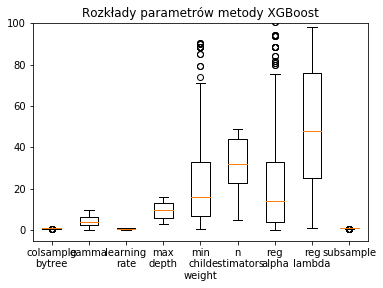

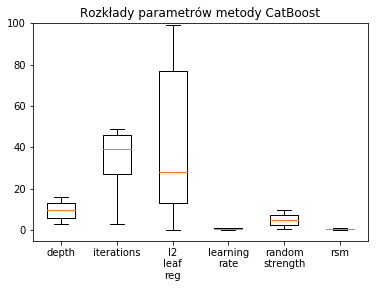

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)


def params_analysis():
    n_seed = 15
    n_metrics = 3
    n_best = 3
    n_dataset = 3
    n_clf_rows = n_best*n_metrics

    params_df = pd.read_csv('params.csv', header=None)
    params_array = params_df.values

    xg_rows = np.concatenate(([False, False], params_df[2] == 'XGBClassifier'), axis=0)
    xg_params = params_array[xg_rows[: np.shape(xg_rows)[0] - 2], :]
    xg_params = np.array([[num(y) for y in x] for x in xg_params])

    cat_rows = np.concatenate(([False, False], params_df[2] == 'CatBoostClassifier'), axis=0)
    cat_params = params_array[cat_rows[: np.shape(cat_rows)[0] - 2], :6]
    cat_params = np.array([[num(y) for y in x] for x in cat_params])

    pd.DataFrame(data=xg_params).to_csv("xgboost_params.csv", index=False)
    pd.DataFrame(data=cat_params).to_csv("catboost_params.csv", index=False)

    fig1, ax1 = plt.subplots()
    ax1.set_title('Rozkłady parametrów metody XGBoost')
    ax1.boxplot(xg_params)
    xg_names = list(elem.replace('_', '\n') for elem in params_array[1, :])
    plt.xticks(np.arange(1, 10), xg_names)
    axes = plt.gca()
    axes.set_ylim([-5, 100])
    plt.show()
    fig1.savefig('xgboost.png')

    fig2, ax2 = plt.subplots()
    ax2.set_title('Rozkłady parametrów metody CatBoost')
    ax2.boxplot(cat_params)
    cat_names = list(elem.replace('_', '\n') for elem in params_array[n_clf_rows*3+1, :6])
    plt.xticks(np.arange(1, 7), cat_names)
    axes = plt.gca()
    axes.set_ylim([-5, 100])
    plt.show()
    fig2.savefig('catboost.png')
    

params_analysis()

## Open In Colab Badge

Anybody can open a copy of any github-hosted notebook within Colab. To make it easier to give people access to live views of GitHub-hosted notebooks,
colab provides a [shields.io](http://shields.io/)-style badge, which appears as follows:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

The markdown for the above badge is the following:

```markdown
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
```

The HTML equivalent is:

```HTML
<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
```

Remember to replace the notebook URL in this template with the notebook you want to link to.